# Particle simulation vs Langevin model

In [1]:
using ProgressMeter
using Revise
using JLD2

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [3]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [4]:
using LaTeXStrings

In [5]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
    arenaParams["E"] = arenaParams["speed"]^2/2
end

extendParams! (generic function with 1 method)

In [6]:
arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>4500,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02,
        "timeStep"=> 0.1
    )

growthParams =
    Dict(
        "ρ"=> 0.002,
        "k"=> 1000,
        "randGrowth"=> false,
        "waitTime"=> 500
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

function fillDensity(arenaParams, growthParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    nT = growthParams["k"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens0 = n0*π*r^2 / V
    fillDensT = nT*π*r^2 / V
    return fillDens0, fillDensT
end

volumeDens(n, r, V) = n*π*r^2/V

timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

println("t0 density: ", fillDensity(arenaParams, growthParams)[1])
println("t0 density: ", fillDensity(arenaParams, growthParams)[2])

Dict{String,Any} with 9 entries:
  "volume"     => 100.0
  "evolveTime" => 4500
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.1
  "E"          => 0.0002
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 500
  "k"          => 1000
  "ρ"          => 0.002
  "randGrowth" => false

t0 density: 0.02010619298297468
t0 density: 0.20106192982974677


### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


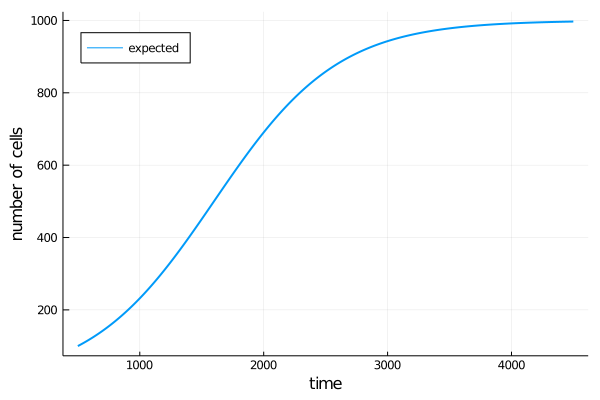

In [7]:
f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
        Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]), 
        label="expected", linewidth=2, legend=:topleft)
xlabel!("time")
ylabel!("number of cells")
display(f1)

Mean Free Path and Friction

In [8]:
# nCells_t = append!(arenaParams["n0"]*ones( Float64, 0:(growthParams["waitTime"]) ), Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
#             growthParams["ρ"], growthParams["k"], arenaParams["n0"]));
nCells_t = Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]);

mfpTheory_t = (x -> Theorist.meanFreePath(x, 4*arenaParams["radius"])).(nCells_t);
frictionTheory_t = ( l -> Theorist.friction(l, arenaParams["E"]) ).(mfpTheory_t);

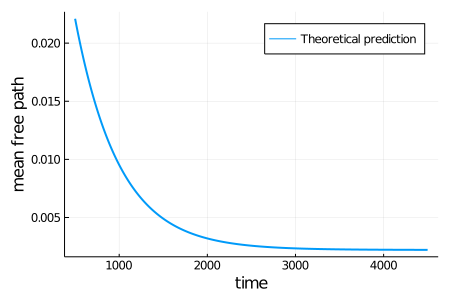

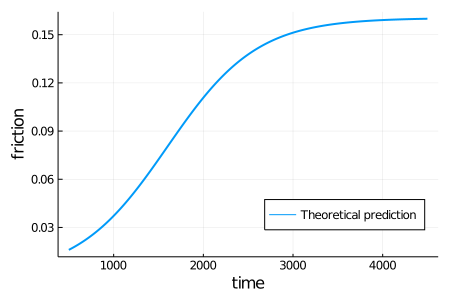

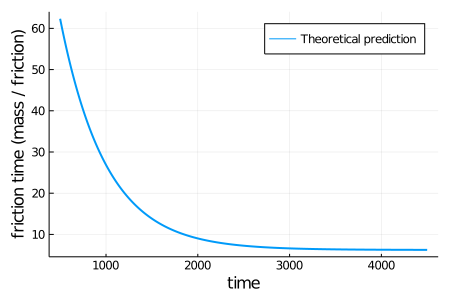

In [9]:
f2 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1, mfpTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:topright,
        size=(450,300))
xlabel!("time")
ylabel!("mean free path")
display(f2)

# savefig(f2, "../Figures/rho"*string(growthParams["ρ"])*"mfp_time.pdf")

f3 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1, 
            arenaParams["speed"]*frictionTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction")
display(f3)

# savefig(f3, "../Figures/rho"*string(growthParams["ρ"])*"friction_time.pdf")

f4 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1,
            1 ./ (arenaParams["speed"]*frictionTheory_t),
        label="Theoretical prediction",
        linewidth=2,
#         legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction time (mass / friction)")
display(f4)

# savefig(f4, "../Figures/rho"*string(growthParams["ρ"])*"frictionTime_time.pdf")

Run Langevin simulations:

In [10]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.0002
246.941032 seconds (5.35 G allocations: 90.651 GiB, 13.27% gc time)


Run a particle simulation:

In [11]:
@time arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID, times_t = 
        BParts.randArenaEvolve(
            arenaParams["n0"], 
            arenaParams["evolveTime"],
            arenaParams["timeStep"],
            arenaParams,
            growthParams);

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

285.837323 seconds (424.30 M allocations: 17.925 GiB, 4.60% gc time)


In [12]:
comVel = BParts.comVel(arena.cellsList)
Eav = BParts.avParticleEnergy(arena.cellsList)

println(comVel)
println(Eav)
println(length(arena.cellsList))

[-4.958838421799298e-19, -8.003739207114656e-20]
0.00019999999999999985
997


In [13]:
# f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
#         volumeDens.(
#             Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
#             growthParams["ρ"], growthParams["k"], arenaParams["n0"]),
#             arenaParams["radius"],
#             arenaParams["volume"]
#         ),
#         label="growth function",
#         linewidth=2,
#         size=(450,300),
#         legend=:topleft)
# plot!(times_t, 
#     volumeDens.(
#         BParts.nCellsTime(cells_T_ID)[1:end],     
#         arenaParams["radius"],
#         arenaParams["volume"]
#     ),
#     label="particle simulation",
#     linewidth=2,
#     linestyle=:dash)
# xlabel!("time")
# ylabel!("occupied surface density")
# display(f1)

# # savefig(f1, "../Figures/surfaceDensity_time_rho"*string(growthParams["ρ"])*".pdf")

Ensemble of particle simulations:

In [14]:
nSims = 50

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], 
                    arenaParams["timeStep"], arenaParams, growthParams; 
                    progress=false, verbose=true);
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
           continue 
        end
        succes = true
    end
end

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.10493857894057163 found in time step0.1
anomalous collision time 8.69658983858394 found in time step0.1
anomalous collision time 20.015175062789908 found in time step0.1
anomalous collision time 2.9161197457778445 found in time step0.1
anomalous collision time 1.7420305784495427 found in time step0.1
anomalous collision time 51.7094797224743 found in time step0.1
anomalous collision time 36.0411399787077 found in time step0.1
anomalous collision time 32.8510143670913 found in time step0.1
anomalous collision time 2.334777062461771 found in time step0.1
anomalous collision time 6.491163509299457 found in time step0.1
anomalous collision time 63.71396289196684 found in time step0.1
anomalous collision time 15.970004610424589 found in time step0.1
anomalous collision time 9.790237201560805 found in time step0.1
anomalous collision time 12.067236628424101 foun

Progress:   2%|▉                                        |  ETA: 3:50:17

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:   4%|█▋                                       |  ETA: 3:58:31

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.12311106075318931 found in time step0.1
anomalous collision time 9.069397484174173 found in time step0.1
anomalous collision time 22.283858323727024 found in time step0.1
anomalous collision time 7.256579531528717 found in time step0.1
anomalous collision time 9.036902913991304 found in time step0.1
anomalous collision time 6.365528266452271 found in time step0.1
anomalous collision time 17.75104359564797 found in time step0.1
anomalous collision time 9.036902913991304 found in time step0.1
anomalous collision time 5.9145507820205045 found in time step0.1
anomalous collision time 18.16710244219834 found in time step0.1
anomalous collision time 9.036902913991304 found in time step0.1
anomalous collision time 2.494051907093518 found in time step0.1
anomalous collision time 22.93037889605512 found in time step0.1
anomalous collision time 18.16

Progress:   6%|██▌                                      |  ETA: 3:44:30

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:   8%|███▎                                     |  ETA: 3:37:36

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
anomalous collision time 0.20566735867327363 found in time step0.1
anomalous collision time 1.266152448695122 found in time step0.1
anomalous collision time 5.343492597887857 found in time step0.1
anomalous collision time 3.320078353008158 found in time step0.1
anomalous collision time 8.761746683978695 found in time step0.1
anomalous collision time 2.8171965785316058 found in time step0.1
anomalous collision time 17.79824610332896 found in time step0.1
anomalous collision time 2.154452750012805 found in time step0.1
anomalous collision time 4.87755203506636 found in time step0.1
anomalous collision time 0.7335940007754121 found in time step0.1
anomalous collision time 20.238180876029727 found in time step0.1
anomalous collision time 1.11823513354391 found in time step0.1
anomalous collision time 13.297513852172917 found in time step0.1
anomalous collision time 2.240

Progress:  10%|████▏                                    |  ETA: 3:31:06

Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  12%|████▉                                    |  ETA: 3:29:16

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  14%|█████▊                                   |  ETA: 3:22:17

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  16%|██████▌                                  |  ETA: 3:17:37

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  18%|███████▍                                 |  ETA: 3:12:04

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  20%|████████▎                                |  ETA: 3:06:30

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  22%|█████████                                |  ETA: 3:01:33

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  24%|█████████▉                               |  ETA: 2:55:56

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 36.789753351047956 found in time step0.1


Progress:  26%|██████████▋                              |  ETA: 2:51:18

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  28%|███████████▌                             |  ETA: 2:49:45

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 8.47109522493829 found in time step0.1
anomalous collision time 12.503892675054882 found in time step0.1
anomalous collision time 13.337865220973393 found in time step0.1
anomalous collision time 14.417723332899827 found in time step0.1
anomalous collision time 0.6370002417606667 found in time step0.1


Progress:  30%|████████████▎                            |  ETA: 2:45:23

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  32%|█████████████▏                           |  ETA: 2:40:05

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.1182171525943717 found in time step0.1


Progress:  34%|██████████████                           |  ETA: 2:35:26

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  36%|██████████████▊                          |  ETA: 2:30:51

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.11843016027126083 found in time step0.1
anomalous collision time 5.637475943416131 found in time step0.1
anomalous collision time 5.667825671910115 found in time step0.1
anomalous collision time 3.798249702646638 found in time step0.1
anomalous collision time 5.66782567191012 found in time step0.1
anomalous collision time 3.238328871152533 found in time step0.1
anomalous collision time 4.461979305588585 found in time step0.1
anomalous collision time 38.74191129825834 found in time step0.1
anomalous collision time 39.37728831427109 found in time step0.1
anomalous collision time 4.995518515899396 found in time step0.1
anomalous collision time 3.249662963238666 found in time step0.1
anomalous collision time 15.31345735187974 found in time step0.1
anomalous collision time 10.160959742477683 found in time step0.1
anomalous collision time 24.6311

Progress:  38%|███████████████▋                         |  ETA: 2:26:21

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02000000000000001
anomalous collision time 8.863076797629882 found in time step0.1
anomalous collision time 8.870440614617111 found in time step0.1
anomalous collision time 8.045357665310787 found in time step0.1
anomalous collision time 8.790523549961396 found in time step0.1
anomalous collision time 0.907134731505608 found in time step0.1
anomalous collision time 5.97146162516717 found in time step0.1
anomalous collision time 31.193347538293004 found in time step0.1
anomalous collision time 7.957218938679022 found in time step0.1
anomalous collision time 2.097695767215566 found in time step0.1
anomalous collision time 63.15502382408989 found in time step0.1
anomalous collision time 0.5785787199747506 found in time step0.1
anomalous collision time 63.155023824089874 found in time step0.1
anomalous collision time 4.647938651072347 found in time step0.1
anomalous collision time 8.333524

Progress:  40%|████████████████▍                        |  ETA: 2:27:55

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  42%|█████████████████▎                       |  ETA: 2:22:55

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  44%|██████████████████                       |  ETA: 2:17:45

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.11535868720642002 found in time step0.1
anomalous collision time 60.654858081465854 found in time step0.1
anomalous collision time 8.01823616039627 found in time step0.1
anomalous collision time 37.7942976155969 found in time step0.1
anomalous collision time 3.5726712691840135 found in time step0.1
anomalous collision time 14.254164464181006 found in time step0.1
anomalous collision time 8.86194411846196 found in time step0.1
anomalous collision time 4.170176859074159 found in time step0.1
anomalous collision time 17.546978573200565 found in time step0.1
anomalous collision time 8.861944118461953 found in time step0.1
anomalous collision time 16.01051226383878 found in time step0.1
anomalous collision time 4.548913139133463 found in time step0.1
anomalous collision time 3.409880680835785 found in time step0.1
anomalous collision time 13.692404182882408 fou

Progress:  46%|██████████████████▉                      |  ETA: 2:13:11

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  48%|███████████████████▋                     |  ETA: 2:08:05

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
anomalous collision time 0.8210139051232628 found in time step0.1
anomalous collision time 9.549490114774969 found in time step0.1
anomalous collision time 2.1920362315099005 found in time step0.1
anomalous collision time 11.511082300970818 found in time step0.1
anomalous collision time 7.0913279528127 found in time step0.1
anomalous collision time 5.79842638049137 found in time step0.1
anomalous collision time 7.502981663001371 found in time step0.1
anomalous collision time 11.175687921594044 found in time step0.1
anomalous collision time 2.7236609425327902 found in time step0.1
anomalous collision time 7.0913279528127 found in time step0.1
anomalous collision time 5.288659779165458 found in time step0.1
anomalous collision time 12.964654147086799 found in time step0.1
anomalous collision time 46.38642142185134 found in time step0.1
anomalous collision time 55.43795

Progress:  50%|████████████████████▌                    |  ETA: 2:03:07

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  52%|█████████████████████▍                   |  ETA: 1:59:53

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  54%|██████████████████████▏                  |  ETA: 1:58:17

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  56%|███████████████████████                  |  ETA: 1:56:16

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  58%|███████████████████████▊                 |  ETA: 1:55:12

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007


Progress:  60%|████████████████████████▋                |  ETA: 1:52:02

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993


Progress:  62%|█████████████████████████▍               |  ETA: 1:48:24

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  64%|██████████████████████████▎              |  ETA: 1:47:25

Building arena...
8 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  66%|███████████████████████████              |  ETA: 1:44:21

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.138568208568742 found in time step0.1


Progress:  68%|███████████████████████████▉             |  ETA: 1:38:48

Building arena...
8 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 2.9406138305599474 found in time step0.1
anomalous collision time 10.835133654502018 found in time step0.1
anomalous collision time 18.418068477977684 found in time step0.1
anomalous collision time 5.268775980112846 found in time step0.1
anomalous collision time 25.67198669333621 found in time step0.1
anomalous collision time 0.7918671989526316 found in time step0.1
anomalous collision time 2.7594750996031308 found in time step0.1
anomalous collision time 25.671986693336144 found in time step0.1
anomalous collision time 19.109791967112272 found in time step0.1
anomalous collision time 4.995659823223916 found in time step0.1
anomalous collision time 25.671986693336116 found in time step0.1
anomalous collision time 8.95273200768606 found in time step0.1
anomalous collision time 5.767160204560263 found in time step0.1
anomalous collision time 7.

Progress:  70%|████████████████████████████▊            |  ETA: 1:31:59

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  72%|█████████████████████████████▌           |  ETA: 1:25:01

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004


Progress:  74%|██████████████████████████████▍          |  ETA: 1:18:12

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  76%|███████████████████████████████▏         |  ETA: 1:11:32

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.10809241407397885 found in time step0.1
anomalous collision time 9.80513945651582 found in time step0.1
anomalous collision time 3.9320094658240548 found in time step0.1
anomalous collision time 9.805139456515814 found in time step0.1
anomalous collision time 4.134099522752326 found in time step0.1
anomalous collision time 3.892683069790708 found in time step0.1
anomalous collision time 3.6243701043121113 found in time step0.1
anomalous collision time 9.805139456515867 found in time step0.1
anomalous collision time 0.4127787084281464 found in time step0.1
anomalous collision time 0.9181806207647336 found in time step0.1
anomalous collision time 2.3425643933023186 found in time step0.1
anomalous collision time 0.9181806207647336 found in time step0.1
anomalous collision time 3.6631003835998426 found in time step0.1
anomalous collision time 1

Progress:  78%|████████████████████████████████         |  ETA: 1:05:01

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993


Progress:  80%|████████████████████████████████▊        |  ETA: 0:58:42

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:52:40

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:46:47

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
anomalous collision time 0.2534849464099603 found in time step0.1
anomalous collision time 8.213800645976479 found in time step0.1
anomalous collision time 10.425505774398694 found in time step0.1
anomalous collision time 5.51194086958142 found in time step0.1
anomalous collision time 11.98368884939493 found in time step0.1
anomalous collision time 5.25823080231072 found in time step0.1
anomalous collision time 1.787423692171576 found in time step0.1
anomalous collision time 3.5690035779734113 found in time step0.1
anomalous collision time 8.59825440552771 found in time step0.1
anomalous collision time 4.481255883514825 found in time step0.1
anomalous collision time 5.307915971532636 found in time step0.1
anomalous collision time 21.4724463995185 found in time step0.1
anomalous collision time 4.481255883514825 found in time step0.1
anomalous collision time 5.67705306

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:41:09

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:35:09

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:29:19

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000018
anomalous collision time 0.508938284893614 found in time step0.1
anomalous collision time 6.3041669128839875 found in time step0.1
anomalous collision time 3.36805321751181 found in time step0.1
anomalous collision time 6.4579080746647275 found in time step0.1
anomalous collision time 4.592869706754326 found in time step0.1
anomalous collision time 9.893740592338846 found in time step0.1
anomalous collision time 13.355302425330295 found in time step0.1
anomalous collision time 4.011735676052122 found in time step0.1
anomalous collision time 5.0375518199641895 found in time step0.1
anomalous collision time 0.18259893640721406 found in time step0.1
anomalous collision time 7.885028629036764 found in time step0.1
anomalous collision time 21.718041213395672 found in time step0.1
anomalous collision time 11.739394674670809 found in time step0.1
anomalous collision time 3.

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:23:40

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:17:47

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.20776266520038794 found in time step0.1
anomalous collision time 12.264584247984768 found in time step0.1
anomalous collision time 3.2633983594470846 found in time step0.1
anomalous collision time 0.1928420546587973 found in time step0.1
anomalous collision time 10.31515377602894 found in time step0.1
anomalous collision time 10.06519889138925 found in time step0.1
anomalous collision time 23.62276803765322 found in time step0.1
anomalous collision time 12.665516618457284 found in time step0.1
anomalous collision time 10.5089978206912 found in time step0.1
anomalous collision time 0.2606579913092798 found in time step0.1
anomalous collision time 6.499410546793511 found in time step0.1
anomalous collision time 0.2606579913092798 found in time step0.1
anomalous collision time 5.702713912466341 found in time step0.1
anomalous collision time 4.

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:11:54

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:05:55

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.11569725821992474 found in time step0.1
anomalous collision time 7.028283744606461 found in time step0.1
anomalous collision time 7.028283744606709 found in time step0.1
anomalous collision time 6.830524188694908 found in time step0.1
anomalous collision time 7.028283744606797 found in time step0.1
anomalous collision time 5.419492664236331 found in time step0.1
anomalous collision time 7.0282837446070205 found in time step0.1
anomalous collision time 11.257945865980613 found in time step0.1
anomalous collision time 3.327612323430389 found in time step0.1
anomalous collision time 3.327612323430389 found in time step0.1
anomalous collision time 6.079964979451037 found in time step0.1
anomalous collision time 10.747995223804445 found in time step0.1
anomalous collision time 5.631441185264886 found in time step0.1
anomalous collision time 12.3

Progress: 100%|█████████████████████████████████████████| Time: 4:55:14


### Mean squared displacement

In [15]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

(501, 4500)

In [16]:
size(pos_Sim[1])[1]

4501

In [17]:
@time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
end

 77.184231 seconds (401.60 M allocations: 44.908 GiB, 15.75% gc time)


In [18]:
length(msd_Sim_t[1])

4000

In [19]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )

(501:1:4500, [0.0, 0.00039763121486181434, 0.0015806918822462474, 0.003546579461931392, 0.006283064408336343, 0.009776311308317534, 0.01402124608346627, 0.019016936269618687, 0.0247523292618235, 0.031209125991751272  …  78.41343618495652, 78.42231998457271, 78.43079978084455, 78.44026949328031, 78.45146476623007, 78.46275161853382, 78.47524235058309, 78.4858079983251, 78.49847616775774, 78.50946611555801])

In [20]:
saveName = "growingPop_multSims_rho"*string(growthParams["ρ"])*".jld2"

@save saveName arenaParams growthParams msd_Sim_t msdPart_t msdLan_t

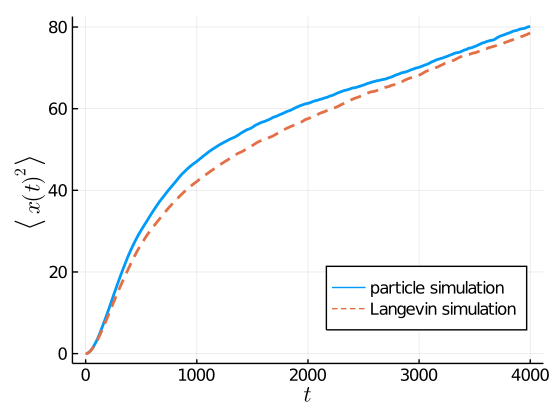

In [21]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
# title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.pdf")

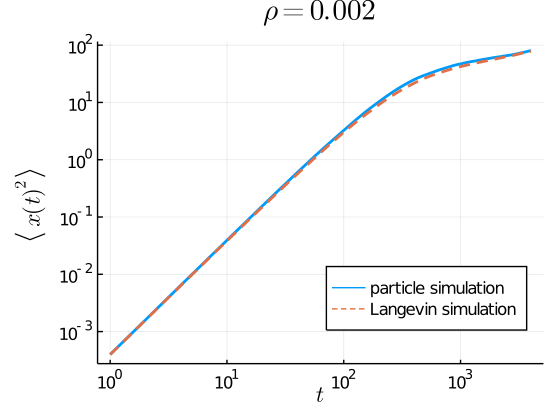

In [22]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    xaxis=:log10, yaxis=:log10,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/growingPop_msd_logPlot_rho"*string(growthParams["ρ"])*".png")
# savefig(p2, "../Figures/growingPop_msd_logPlot_rho"*string(growthParams["ρ"])*".pdf")

In [23]:
# msdSingles_Sim = []

# for sim in 1:nSims
#     msd_t = BParts.meanSquaredDisplacement(pos_Sim[sim], msdTimes)
#     push!(msdSingles_Sim, msd_t)
# end

In [24]:
# p2 = plot(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=3,
#     legend=:topleft,
#     size=(500,300),
#     dpi=140)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation average", linestyle=:dashdot, linewidth=3)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart0_t[2:end])
# for s in 1:nSims
#     plot!(1:msdTimes[2]-msdTimes[1], msdSingles_Sim[s][2:end],
# #         label="particle simulation "*string(s),
#         label="")
# end
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p2)

# # savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdSingles_time.pdf")